In [1]:
import os
import time 
import shutil
import random

import itertools
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import skimage.io
import PIL.Image as Image
import matplotlib.pyplot as plt
%matplotlib inline


# from PIL import Image
from tqdm import tqdm
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from IPython.display import display

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.models as models
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from pretrainedmodels import xception,resnext101_32x4d,resnext101_64x4d,resnet101,resnet50,vgg19_bn
from torch.autograd import Variable
from tensorboardX import SummaryWriter

# np.random.seed(666)
# torch.manual_seed(666)
# torch.cuda.manual_seed_all(666)
# random.seed(666)

In [3]:
file_name = 'vgg19_bn_focalloss'

In [4]:
image = 'data/NG/innerDust/innerDust (45).BMP'

In [5]:
checkpoint_path = './model/%s/checkpoint.pth.tar' % file_name
output_path = './model/%s/checkpoint.onnx' % file_name
pb_path = './model/%s/checkpoint.pb'%file_name

In [6]:
model = vgg19_bn()
model.last_linear = nn.Linear(4096,8)
checkpoint = torch.load(checkpoint_path)

Image 1:


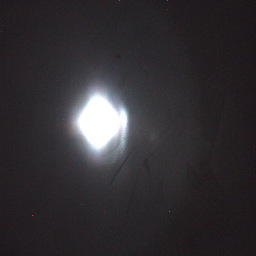

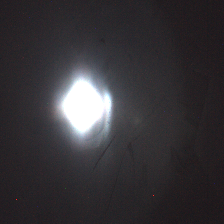

In [7]:
print('Image 1:')
img = Image.open(image).resize((256, 256))
display(img)
width, height = img.size

new_width,new_height = 224,224
left = (width - new_width)/2
top = (height - new_height)/2
right = (width + new_width)/2
bottom = (height + new_height)/2

img1 = img.crop((left, top, right, bottom))

display(img1)
img1 = np.asarray(img1, dtype=np.float32)/255.0
imgarray = ((img1-np.array([0.485, 0.456, 0.406]))/np.array([0.229, 0.224, 0.225])).reshape((1,3,224,224))

In [8]:
img1.shape

(224, 224, 3)

In [9]:
model.eval()
image_var = torch.tensor(imgarray, requires_grad=False).float()  # for pytorch 0.4
with torch.no_grad():
    y_pred = model(image_var)
    # sigmoid to prob
    sm = nn.Softmax()
    sm_out = sm(y_pred)       
label_predicts = np.argmax(sm_out)

C:\Users\sunny\Anaconda3\envs\pytorch-0.4\lib\site-packages\ipykernel\__main__.py:7: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [10]:
label_predicts

tensor(3)

In [11]:
new_state_dict = OrderedDict()
for k, v in checkpoint['state_dict'].items():
    name = k[7:] # remove module.
    new_state_dict[name] = v

In [12]:
model.load_state_dict(new_state_dict)

In [13]:
dummy_input = Variable(torch.randn(1, 3, 224,224))
torch.onnx.export(model, dummy_input, output_path)

In [14]:
import onnx
from onnx_tf.backend import prepare

# Load the ONNX file
model = onnx.load(output_path)

# Import the ONNX model to Tensorflow
tf_rep = prepare(model,strict=False)

d:\pythonworkspace\pytorchworkspace\onnx-tensorflow\onnx_tf\common\handler_helper.py:70: UserWarning: Fail to get since_version of Acos in domain `` with max_inclusive_version=6. Set to 1.
  handler.ONNX_OP, handler.DOMAIN, version))
d:\pythonworkspace\pytorchworkspace\onnx-tensorflow\onnx_tf\common\handler_helper.py:70: UserWarning: Fail to get since_version of Asin in domain `` with max_inclusive_version=6. Set to 1.
  handler.ONNX_OP, handler.DOMAIN, version))
d:\pythonworkspace\pytorchworkspace\onnx-tensorflow\onnx_tf\common\handler_helper.py:70: UserWarning: Fail to get since_version of Atan in domain `` with max_inclusive_version=6. Set to 1.
  handler.ONNX_OP, handler.DOMAIN, version))
d:\pythonworkspace\pytorchworkspace\onnx-tensorflow\onnx_tf\common\handler_helper.py:73: UserWarning: Unknown op ConstantLike in domain `ai.onnx`.
  handler.ONNX_OP, handler.DOMAIN or "ai.onnx"))
d:\pythonworkspace\pytorchworkspace\onnx-tensorflow\onnx_tf\common\handler_helper.py:70: UserWarning: 

Image 1:


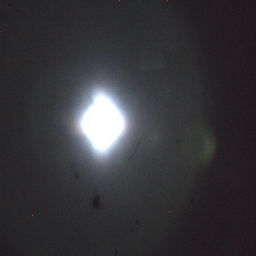

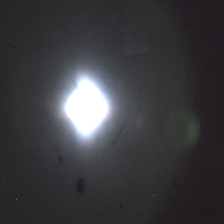


The digit is classified as  5


In [15]:
import numpy as np
from IPython.display import display
from PIL import Image

print('Image 1:')
img = Image.open(image).resize((256, 256))
display(img)
width, height = img.size

new_width,new_height = 224,224
left = (width - new_width)/2
top = (height - new_height)/2
right = (width + new_width)/2
bottom = (height + new_height)/2

img1 = img.crop((left, top, right, bottom))

display(img1)
img1 = np.asarray(img1, dtype=np.float32)/255.0
imgarray = ((img1-np.array([0.485, 0.456, 0.406]))/np.array([0.229, 0.224, 0.225])).reshape((1,3,224,224))

print()

output = tf_rep.run(imgarray)
print('The digit is classified as ', np.argmax(output))

In [16]:
import tensorflow as tf

In [17]:
onnx_model = onnx.load(output_path)
export_path = pb_path

onnx.checker.check_model(onnx_model)

print('prepare tf model')
tf_rep = prepare(onnx_model,strict=True)

if os.path.exists(export_path):
    os.remove(export_path)

with tf.Session() as persisted_sess:
    print("load graph")
    persisted_sess.graph.as_default()
    tf.import_graph_def(tf_rep.graph.as_graph_def(), name='')

    i_tensors = []
    o_tensors = []
    inputs = {}
    outputs = {}

    for i in tf_rep.inputs:
        t = persisted_sess.graph.get_tensor_by_name(
            tf_rep.tensor_dict[i].name
        )
        i_tensors.append(t)
        tensor_info = tf.saved_model.utils.build_tensor_info(t)
        inputs[t.name.split(':')[0].lower()] = tensor_info
        print(
            'input tensor [name=%s, type=%s, shape=%s]'
            % (t.name, t.dtype.name, t.shape.as_list())
        )
    print('')

    for i in tf_rep.outputs:
        t = persisted_sess.graph.get_tensor_by_name(
            tf_rep.tensor_dict[i].name
        )
        o_tensors.append(t)
        tensor_info = tf.saved_model.utils.build_tensor_info(t)
        outputs[t.name.split(':')[0]] = tensor_info
        print(
            'output tensor [name=%s, type=%s, shape=%s]'
            % (t.name, t.dtype.name, t.shape.as_list())
        )

    feed_dict = {}
    for i in i_tensors:
        feed_dict[i] = np.random.rand(*i.shape.as_list()).astype(i.dtype.name)

    print('test run:')
    res = persisted_sess.run(o_tensors, feed_dict=feed_dict)
    print(res)

    # print('INPUTS')
    # print(inputs)
    # print('OUTPUTS')
    # print(outputs)
    prediction_signature = (
        tf.saved_model.signature_def_utils.build_signature_def(
            inputs=inputs,
            outputs=outputs,
            method_name=tf.saved_model.signature_constants.PREDICT_METHOD_NAME)
    )
    builder = tf.saved_model.builder.SavedModelBuilder(export_path)
    builder.add_meta_graph_and_variables(
        persisted_sess, [tf.saved_model.tag_constants.SERVING],
        signature_def_map={
            tf.saved_model.signature_constants.DEFAULT_SERVING_SIGNATURE_DEF_KEY:
                prediction_signature
        })
    builder.save()

prepare tf model


d:\pythonworkspace\pytorchworkspace\onnx-tensorflow\onnx_tf\common\handler_helper.py:70: UserWarning: Fail to get since_version of Acos in domain `` with max_inclusive_version=6. Set to 1.
  handler.ONNX_OP, handler.DOMAIN, version))
d:\pythonworkspace\pytorchworkspace\onnx-tensorflow\onnx_tf\common\handler_helper.py:70: UserWarning: Fail to get since_version of Asin in domain `` with max_inclusive_version=6. Set to 1.
  handler.ONNX_OP, handler.DOMAIN, version))
d:\pythonworkspace\pytorchworkspace\onnx-tensorflow\onnx_tf\common\handler_helper.py:70: UserWarning: Fail to get since_version of Atan in domain `` with max_inclusive_version=6. Set to 1.
  handler.ONNX_OP, handler.DOMAIN, version))
d:\pythonworkspace\pytorchworkspace\onnx-tensorflow\onnx_tf\common\handler_helper.py:73: UserWarning: Unknown op ConstantLike in domain `ai.onnx`.
  handler.ONNX_OP, handler.DOMAIN or "ai.onnx"))
d:\pythonworkspace\pytorchworkspace\onnx-tensorflow\onnx_tf\common\handler_helper.py:70: UserWarning: 

load graph
input tensor [name=0:0, type=float32, shape=[1, 3, 224, 224]]

output tensor [name=add_19:0, type=float32, shape=[1, 8]]
test run:
[array([[ 1.6037228 , -1.7727587 ,  0.17239168, -1.1346207 , -1.5987478 ,
         1.4059737 ,  1.2569089 ,  1.0599444 ]], dtype=float32)]
INFO:tensorflow:No assets to save.
INFO:tensorflow:No assets to write.
INFO:tensorflow:SavedModel written to: ./model/vgg19_bn_focalloss/checkpoint.pb\saved_model.pb


In [ ]:
label_names